## Stats o'clock

In Python you can also do statistics. There are a couple different packages to do that. Most of them build on scipy the main library for scientific computing in python (https://docs.scipy.org/doc/scipy/getting_started.html). However scipy is not always easy to use, if you are just getting started.. 

Therefore it may be sometimes more convenient to take a simpler option. One of the most straightforward to use packages that offers a lot of basic statistical models is pingouin (https://pingouin-stats.org/index.html).


In [1]:
import pingouin as pg

In [2]:
#Import also some other useful packages that we already know
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#set-up our favorite plotting conditions
sns.set_style('ticks')
sns.set_context('poster')

In [3]:
#lets read the preprocessed data for further statistical processing
df_movie = pd.read_csv('https://raw.githubusercontent.com/schmidtfa/course_materials/main/introduction_python/data/netflix_preprocessed.csv')

/usr/local/Caskroom/miniconda/base/envs/analysis/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
df_movie

,Title,As of,Rank,Year to Date Rank,Last Week Rank,Title.1,Type,Netflix Exclusive,Netflix Release Date,Days In Top 10,Viewership Score,year
0,#Alive,2020-09-14,8,6,-,#Alive,Movie,Yes,2020-09-08,6,34,2020
1,17 Again,2021-01-08,8,5,-,17 Again,Movie,No,2021-01-01,7,33,2021
2,1BR,2020-08-29,10,6,-,1BR,Movie,No,2020-08-23,5,16,2020
3,2 Hearts,2021-06-13,10,10,4,2 Hearts,Movie,No,2021-06-02,11,57,2021
4,21 Jump Street,2021-11-10,10,9,5,21 Jump Street,Movie,No,2021-11-01,9,41,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
350,Yes Day,2021-03-28,3,4,1,Yes Day,Movie,Yes,2021-03-12,15,126,2021
351,"Yes, God, Yes",2020-10-26,10,10,-,"Yes, God, Yes",Movie,No,2020-10-22,4,11,2020
352,Yogi Bear,2020-10-06,10,8,-,Yogi Bear,Movie,No,2020-10-01,4,8,2020
353,Your Highness,2021-05-04,9,-,-,Your Highness,Movie,No,2021-05-01,1,2,2021


We previously identified that netflix exclusive movies were "descriptively" on average longer in the Top 10, then other movies that were not necessarily netflix exclusive. Lets now try to find out whether that difference is statistically significant.

In [5]:
#lets first see whether there is a difference in the number of observations across groups
np.unique(df_movie['Netflix Exclusive'], return_counts=True) #sample size is roughly equal.

(array(['No', 'Yes'], dtype=object), array([175, 180]))

## Plotting time

Now lets plot a histogramm of our data in both conditions to see how our data is distributed. Its always a good idea to visualize our data before we run statistics, because we might identify some weirdness in our data that we should be aware off to pick a proper statistical method

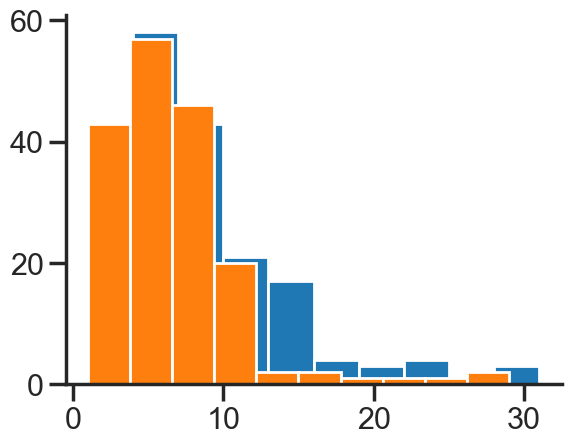

In [6]:

plt.hist(df_movie[df_movie['Netflix Exclusive'] == "Yes"]['Days In Top 10'])
plt.hist(df_movie[df_movie['Netflix Exclusive'] == "No"]['Days In Top 10'])
sns.despine()

## Not really normally distributed

Looking at the distribution of our data we notice immediately that it doesnt follow a proper normal distribution. If we were to try to analyze the data using a glm we would probably use a poisson or negative binomial distribution. To analyze the data. But for now lets stick with some simple statistics.

Lets first confirm our observation of non-normality by running a shapiro-wilk test embedded in pingouin

https://pingouin-stats.org/build/html/generated/pingouin.normality.html#pingouin.normality

In [7]:
pd.concat([pg.normality(df_movie[df_movie['Netflix Exclusive'] == "Yes"]['Days In Top 10']),
           pg.normality(df_movie[df_movie['Netflix Exclusive'] == "No"]['Days In Top 10'])])

,W,pval,normal
Days In Top 10,0.863499,1.132679e-11,False
Days In Top 10,0.842643,1.860699e-12,False


As our data is not normal distributed lets compare both conditions using a mann-whitney u test

https://pingouin-stats.org/build/html/generated/pingouin.mwu.html#pingouin.mwu

In [8]:
pg.mwu(df_movie[df_movie['Netflix Exclusive'] == "Yes"]['Days In Top 10'],
         df_movie[df_movie['Netflix Exclusive'] == "No"]['Days In Top 10']
         )

,U-val,alternative,p-val,RBC,CLES
MWU,18754.5,two-sided,0.001819,-0.190762,0.595381


There seems to be a significant difference between both groups. i.e. Netflix exclusive shows stay longer in the Top 10 then shows that are not necessarily Netflix exclusive.

How do we interpret this? Can we really say that netflix is pushing their shows? Or are Netflix exclusive shows also more popular indicated by the "Viewership Score"? 

Lets find out... :)


For this we need to reload the old data, because the "Viewership score" in the current movie data is based on the last day the show was in the Top 10. Its probably more informative to take the average "Viewership score" across the whole time a movie was in the top 10.

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/schmidtfa/course_materials/main/introduction_python/data/netflix_daily_top_10.csv')
df_view = df.groupby('Title').mean().reset_index()

But what do we do now? The average top 10 value is not really informative. Also the data now still contains our outlier cocomelon...

Dont worry pandas is there to save us :)

We can use the awesome "merge" method to merge two different dataframes along one or more shared columns.

In [10]:
if 'Viewership Score' in df_movie.columns: 
    df_movie.drop('Viewership Score', axis=1, inplace=True) #note when running this twice we get an error because we modified the df in place
df_merge = df_movie.merge(df_view[['Title', 'Viewership Score']], on='Title')

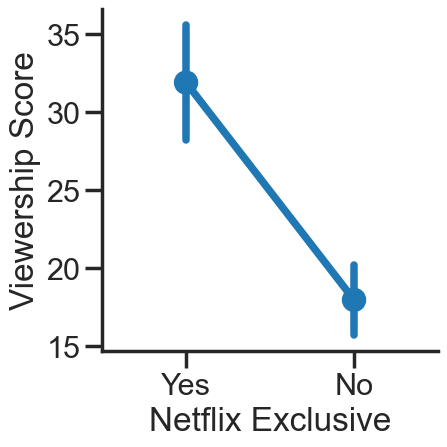

In [13]:
#Lets see how this looks like..
#Seems like shows that are netflix exclusive receive much higher viewership scores on average than show that are not exclusive
sns.catplot(data=df_merge, x='Netflix Exclusive', y='Viewership Score',  kind='point')

## Now its stats time again.

After having a look at our data seeing that "Netflix Exclusive" are much more popular we may want to run our analysis controlling for the influence of viewership score.

Ideally we can do this in the simple case using a prepackaged ANCOVA implementation. 
However, there are some shortcomings..

We already saw that our data is not normally distributed.

Lets check the other assumptions. According to https://www.statisticshowto.com/ancova/#assumptions.

* Normality: the dependent variable should be roughly normal for each of category of independent variables.
* Data should show homogeneity of variance.
* The covariate and dependent variable (at each level of independent variable) should be linearly related.
* Your data should be homoscedastic of Y for each value of X.
* The covariate and the independent variable shouldn’t interact. In other words, there should be homogeneity of regression slopes.

In [12]:
pg.homoscedasticity(data=df_merge, dv='Days In Top 10', group='Netflix Exclusive', method='bartlett')

,T,pval,equal_var
bartlett,9.167384,0.002464,False


Alright so there is no normality and no homogenity of variance. This means running an ancova, which has these assumptions not the best idea... Lets still do it for educational purposes but maybe switch to a more appropriate test in the next notebooks.

In [13]:
pg.ancova(data=df_merge, dv='Days In Top 10', between='Netflix Exclusive', covar='Viewership Score')

,Source,SS,DF,F,p-unc,np2
0,Netflix Exclusive,134.277795,1,30.141839,7.701241e-08,0.078876
1,Viewership Score,7560.192804,1,1697.064795,1.063511e-136,0.828214
2,Residual,1568.112116,352,NaN,NaN,NaN


So we observed a significant difference indicating based on previous results that movies that are netflix exclusive are staying longer in the top 10 then others, even when controlling for the viewership score. 

However, there are some shortcomings...
1. For once we didnt meet any assumptions for our performed statistics. 
2. Furthermore, we dont know the rules for staying in the top 10. Maybe it isnt dependent on the Viewership Score, but on the number of views. We dont have access to these numbers so we cant really conclude anything so far :)

But lets look in a future notebook to see whether or not bayes might help us with at least running our statistics properly

In [14]:
#to do this lets first save our file
df_merge.to_csv('./data/netflix_merged.csv')